In [46]:
#import pkgs
import pandas as pd
import numpy as np
import requests
import string
import nltk
import matplotlib.pyplot as plt
from io import BytesIO
from statistics import mean
from sklearn.model_selection import KFold
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn import metrics
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to C:\Users\Ciaran
[nltk_data]     Mc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Ciaran
[nltk_data]     Mc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Ciaran
[nltk_data]     Mc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Ciaran
[nltk_data]     Mc\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [62]:
#load data from github
url = 'https://raw.githubusercontent.com/cmcswiggan/CIND820/main/SMS_Spam_Dataset'
url_test = 'https://raw.githubusercontent.com/cmcswiggan/CIND820/main/SMS_Spam_Dataset_Case_1.txt'

data = requests.get(url).content
data_test = requests.get(url_test).content


smsData = pd.read_csv(BytesIO(data), sep = '\t', header = None, names = ['Category', 'SMS Message'])
smsTest = pd.read_csv(BytesIO(data_test), sep = '\t', header = None, names = ['Category', 'SMS Message'])

#check data loaded as expected
smsData.head()
smsTest.head()

,Category,SMS Message
0,ham,"Ok, see you soon!"
1,ham,"Nah, they should get a couple more haha"
2,ham,What time you want me to visit today
3,ham,What do you wanna do ??
4,ham,ooh you mean the number of spots


In [64]:
#assign stopwords and punctuation to variables
stopWords = nltk.corpus.stopwords.words('english')
punctuation = string.punctuation

In [65]:
#pre_Process function defined - list required for lemmatization step

def pre_Process(sms):
    
    #remove punctuation, toeknize and remove stopwords
    process = "".join([char.lower() for char in sms if char not in punctuation])
    tokenize = nltk.tokenize.word_tokenize(process)
    remove_stopwords = [word for word in tokenize if word not in stopWords]
    return remove_stopwords

#add processed column
smsData['Processed'] = smsData['SMS Message'].apply(lambda x: pre_Process(x))
smsTest['Processed'] = smsTest['SMS Message'].apply(lambda x: pre_Process(x))

#check dataframe data as anticipated
smsData.head()
smsTest.head()

,Category,SMS Message,Processed
0,ham,"Ok, see you soon!","[ok, see, soon]"
1,ham,"Nah, they should get a couple more haha","[nah, get, couple, haha]"
2,ham,What time you want me to visit today,"[time, want, visit, today]"
3,ham,What do you wanna do ??,"[wan, na]"
4,ham,ooh you mean the number of spots,"[ooh, mean, number, spots]"


In [66]:
#define function for lemmatizing words

def lemm (sms):
    
    lem = [lemmatizer.lemmatize(word) for word in sms]
    return lem

#replace processed column with lemmatized column
smsData['Processed'] = smsData['Processed'].apply(lambda x: lemm(x))
smsTest['Processed'] = smsTest['Processed'].apply(lambda x: lemm(x))

#check dataframe data as anticipated
smsTest.head()

,Category,SMS Message,Processed
0,ham,"Ok, see you soon!","[ok, see, soon]"
1,ham,"Nah, they should get a couple more haha","[nah, get, couple, haha]"
2,ham,What time you want me to visit today,"[time, want, visit, today]"
3,ham,What do you wanna do ??,"[wan, na]"
4,ham,ooh you mean the number of spots,"[ooh, mean, number, spot]"


In [67]:
#add cell with processed data as a string after processing
smsData['Processedstr'] = [' '.join(map(str, l)) for l in smsData['Processed']]
smsTest['Processedstr'] = [' '.join(map(str, l)) for l in smsTest['Processed']]

#assign 0 for ham and 1 for spam
for i in range(len(smsData['Category'])):
    if smsData.iloc[i, 0] == 'ham':
        smsData.iloc[i, 0] = 1
    else:
        smsData.iloc[i, 0] = 0
        
for i in range(len(smsTest['Category'])):
    if smsTest.iloc[i, 0] == 'ham':
        smsTest.iloc[i, 0] = 1
    else:
        smsTest.iloc[i, 0] = 0

#remove unwanted columns
smsData = smsData[['Category', 'Processedstr']]
smsTest = smsTest[['Category', 'Processedstr']]

#check updated data frame
smsData.head()
smsTest.head()

,Category,Processedstr
0,1,ok see soon
1,1,nah get couple haha
2,1,time want visit today
3,1,wan na
4,1,ooh mean number spot


In [58]:
sms_test_label = smsTest['Processedstr']
sms_test_label

0                                           ok see soon
1                                   nah get couple haha
2                                 time want visit today
3                                                wan na
4                                  ooh mean number spot
5                miss got ta plan dinner soon something
6                             really fanbase thanking u
7                                        ya serious fun
8                                       sorry call hour
9                                absolutely yes v smart
10                     claiming link ubereatsref7400com
11    canada post courier attempted deliver parcel c...
12         amazon reminder would like payment reply yes
13                                              sending
14    noticed extra charge made revenue year 2022 vi...
15                          got 34065 claim reply refer
16    policy licence plate sticker amended service o...
17    rogers sent back total overcharged bill la

In [73]:
#split data into 10 folds to run model on each fold
kf = KFold(n_splits = 10, shuffle = True, random_state = 5)

#counter
i = 0

#initiate empty lists and data frame
fold = []
acc = []
prec = []
rec = []
f1 = []
fprt = []
met = []
res = pd.DataFrame()

#split data/loop over each fold and run model 
for train_index, test_index in kf.split(smsData.Processedstr, smsData.Category):
    sms_train, sms_test, label_train, label_test = smsData.Processedstr[train_index], smsData.Processedstr[test_index], smsData.Category[train_index], smsData.Category[test_index]
    
    #labels as integers
    label_train = label_train.astype('int')
    label_test = smsTest['Category'].astype('int')
    
    #fit and transform training and test data
    vect = CountVectorizer().fit(sms_train)
    train_vectorized = vect.transform(sms_train)
    
    #fitting a multinomial Naive Bayes Classifier Model with smoothing alpha=0.1
    model = MultinomialNB(alpha=0.1)
    model_fit = model.fit(train_vectorized, label_train)

    #making predictions
    train_predict = model.predict(vect.transform(sms_test_label))

    #run confusion matrix
    tn, fp, fn, tp = confusion_matrix(label_test, train_predict, labels = [1, 0]).ravel()
    
    #calculate accuracy, precision, recall, F1 score, False Positive Rate
    a = (tp + tn)/(tp + fp + fn + tn)
    p = tp/(tp + fp)
    r = tp/(tp + fn)
    f = (2 * (p * r))/(p + r)
    fpr = fp / (tn + fp)
    
    i = i + 1
    
    #append results to each empty list
    fold.append(i)
    acc.append(a)
    prec.append(p)
    rec.append(r)
    f1.append(f)
    fprt.append(fpr)
    met.append([tp, fp, tn, fn])

#fill dataframe with results from the model/cross-validation 
res['Fold'] = fold    
res['Accuracy'] = acc
res['Precision'] = prec
res['Recall'] = rec
res['F1'] = f1
res['FPR'] = fprt
res['Metrics'] = met

res

,Fold,Accuracy,Precision,Recall,F1,FPR,Metrics
0,1,0.65,1.0,0.3,0.461538,0.0,"[3, 0, 10, 7]"
1,2,0.65,1.0,0.3,0.461538,0.0,"[3, 0, 10, 7]"
2,3,0.65,1.0,0.3,0.461538,0.0,"[3, 0, 10, 7]"
3,4,0.70,1.0,0.4,0.571429,0.0,"[4, 0, 10, 6]"
4,5,0.65,1.0,0.3,0.461538,0.0,"[3, 0, 10, 7]"
5,6,0.65,1.0,0.3,0.461538,0.0,"[3, 0, 10, 7]"
6,7,0.65,1.0,0.3,0.461538,0.0,"[3, 0, 10, 7]"
7,8,0.65,1.0,0.3,0.461538,0.0,"[3, 0, 10, 7]"
8,9,0.70,1.0,0.4,0.571429,0.0,"[4, 0, 10, 6]"
9,10,0.65,1.0,0.3,0.461538,0.0,"[3, 0, 10, 7]"


In [74]:
#split list of list in dataframe
split = pd.DataFrame(res['Metrics'].to_list(), columns = ['TP', 'FP', 'TN', 'FN'])

#add split columns to results dataframe
res = pd.concat([res, split], axis = 1)

#drop combined columns
res.drop(columns = 'Metrics', inplace = True)

#check results dataframe
res

print(round(mean(res['F1']), 2))

0.48


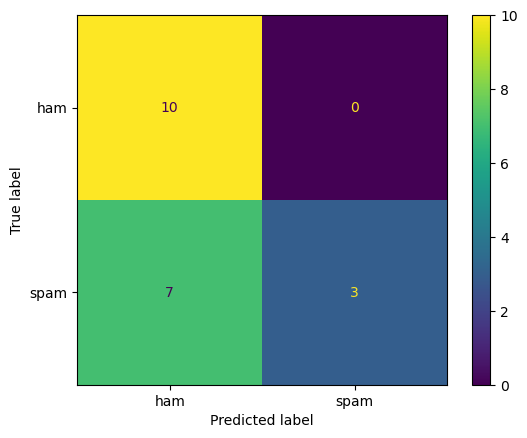

In [61]:
#average results for visualization
TP = round(mean(res['TP']),0)
FP = round(mean(res['FP']),0)
TN = round(mean(res['TN']),0)
FN = round(mean(res['FN']),0)

#create array with confusion matrix results
data = np.array([[TN, FP], [FN, TP]])

#create matrix
cm_display = metrics.ConfusionMatrixDisplay(data, display_labels = ['ham', 'spam'])

#plot
cm_display.plot()
plt.show()

In [10]:
#store list to for use in statistical comparison
f1_nb_case3 = res.loc[:,'F1'].tolist()
fpr_nb_case3 = res.loc[:,'FPR'].tolist()

%store f1_nb_case3
%store fpr_nb_case3

Stored 'f1_nb_case3' (list)
Stored 'fpr_nb_case3' (list)
